In [1]:
!pip install --upgrade pip
!pip install ipykernel
!pip install seaborn
!pip install pandas


In [2]:
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.7.1
!pip install scikit-learn matplotlib

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
    --------------------------------------- 0.3/15.5 MB ? eta -:--:--
    --------------------------------------- 0.3/15.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.5 MB 762.0 kB/s eta 0:00:20
   - -------------------------------------- 0.5/15.5 MB 762.0 kB/s eta 0:00:20
   -- ------------------------------------- 0.8/15.5 MB 799.2 kB/s eta 0:00:19
   -- ------------------------------------- 0.8/15.5 MB 799.2 kB/s eta 0:00:19
   -- ------------------------------------- 1.0/15.5 MB 718.9 kB/s eta 0:00:21
   -- ------------------------------------- 1.0/15.5 MB 718.9 kB/s eta 0:00:21
   --- ------------------------------------ 1.3/15.5 MB 691.7 kB/s eta 0:00:21
   --- ------------------------------------ 1.3/15.5 MB 691.7 kB/s eta 0:00:21
   ---- ----------------------------------- 1.6/15.5 MB 693.1 kB/s eta 0:00:21
   ---- -

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import joblib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

Best SVM params: OrderedDict({'pca__n_components': 4, 'svm__C': 43.51397079152049, 'svm__gamma': 0.05388550972627239, 'svm__kernel': 'rbf'})
Best k-NN params: OrderedDict({'knn__n_neighbors': 13, 'knn__p': 2, 'knn__weights': 'distance', 'pca__n_components': 3})
Best XGBoost params: OrderedDict({'pca__n_components': 5, 'xgb__colsample_bytree': 0.9416576386904312, 'xgb__learning_rate': 0.005643956165481529, 'xgb__max_depth': 10, 'xgb__n_estimators': 705, 'xgb__subsample': 0.5311564704220357})

Ensemble Test Accuracy: 0.972972972972973

Classification Report (Ensemble):
                      precision    recall  f1-score   support

          Fish Sauce       0.90      1.00      0.95         9
        Oyster Sauce       1.00      0.89      0.94         9
           Soy Sauce       1.00      1.00      1.00        10
Worcestershire Sauce       1.00      1.00      1.00         9

            accuracy                           0.97        37
           macro avg       0.97      0.97      0.97 

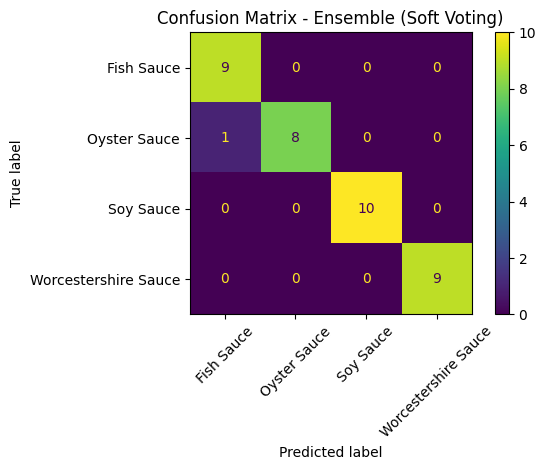

In [5]:
# ------------------------
# Load dataset
# ------------------------
main_voc_df = pd.read_csv("final_trainingset.csv")
X = main_voc_df.drop(columns=["Label"])
y = main_voc_df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# ------------------------
# Encode labels for XGBoost, but keep decoded predictions later
# ------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# ------------------------
# SVM (Bayesian Optimization)
# ------------------------
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("svm", SVC(probability=True, class_weight="balanced", random_state=42))
])

svm_space = {
    "pca__n_components": Integer(2, min(20, X.shape[1])),
    "svm__C": Real(1e-2, 1e3, prior="log-uniform"),
    "svm__gamma": Real(1e-5, 1e-1, prior="log-uniform"),
    "svm__kernel": Categorical(["rbf"])
}

svm_search = BayesSearchCV(
    svm_pipe, svm_space, n_iter=40, cv=cv, scoring="accuracy",
    n_jobs=-1, random_state=42, refit=True
)
svm_search.fit(X_train, y_train_enc)
best_svm = svm_search.best_estimator_

print("Best SVM params:", svm_search.best_params_)


# ------------------------
# k-NN (Bayesian Optimization)
# ------------------------
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("knn", KNeighborsClassifier())
])

knn_space = {
    "pca__n_components": Integer(2, min(20, X.shape[1])),
    "knn__n_neighbors": Integer(1, 30),
    "knn__weights": Categorical(["uniform", "distance"]),
    "knn__p": Integer(1, 2)
}

knn_search = BayesSearchCV(
    knn_pipe, knn_space, n_iter=40, cv=cv, scoring="accuracy",
    n_jobs=-1, random_state=42, refit=True
)
knn_search.fit(X_train, y_train_enc)
best_knn = knn_search.best_estimator_

print("Best k-NN params:", knn_search.best_params_)


# ------------------------
# XGBoost (Bayesian Optimization)
# ------------------------
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("xgb", XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42
    ))
])

xgb_space = {
    "pca__n_components": Integer(2, min(20, X.shape[1])),
    "xgb__n_estimators": Integer(100, 800),
    "xgb__max_depth": Integer(2, 10),
    "xgb__learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
    "xgb__subsample": Real(0.5, 1.0),
    "xgb__colsample_bytree": Real(0.5, 1.0)
}

xgb_search = BayesSearchCV(
    xgb_pipe, xgb_space, n_iter=50, cv=cv, scoring="accuracy",
    n_jobs=-1, random_state=42, refit=True
)
xgb_search.fit(X_train, y_train_enc)
best_xgb = xgb_search.best_estimator_

print("Best XGBoost params:", xgb_search.best_params_)


# ------------------------
# Voting Ensemble (SOFT voting)
# ------------------------
ensemble = VotingClassifier(
    estimators=[
        ("svm", best_svm),
        ("knn", best_knn),
        ("xgb", best_xgb)
    ],
    voting="soft"
)

ensemble.fit(X_train, y_train_enc)

# Predict (encoded) -> decode back to original sauce labels
y_pred_enc = ensemble.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

print("\nEnsemble Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report (Ensemble):")
print(classification_report(y_test, y_pred))

# Confusion Matrix (label strings)
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Ensemble (Soft Voting)")
plt.tight_layout()
plt.show()


In [ ]:

joblib.dump(best_model, 'ensemble_best_model.joblib')
print('Model saved as ensemble_best_model.joblib.')

Model saved as svm_best_model.joblib.


C:\Users\acotj\AppData\Local\Temp\ipykernel_20576\2289986022.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


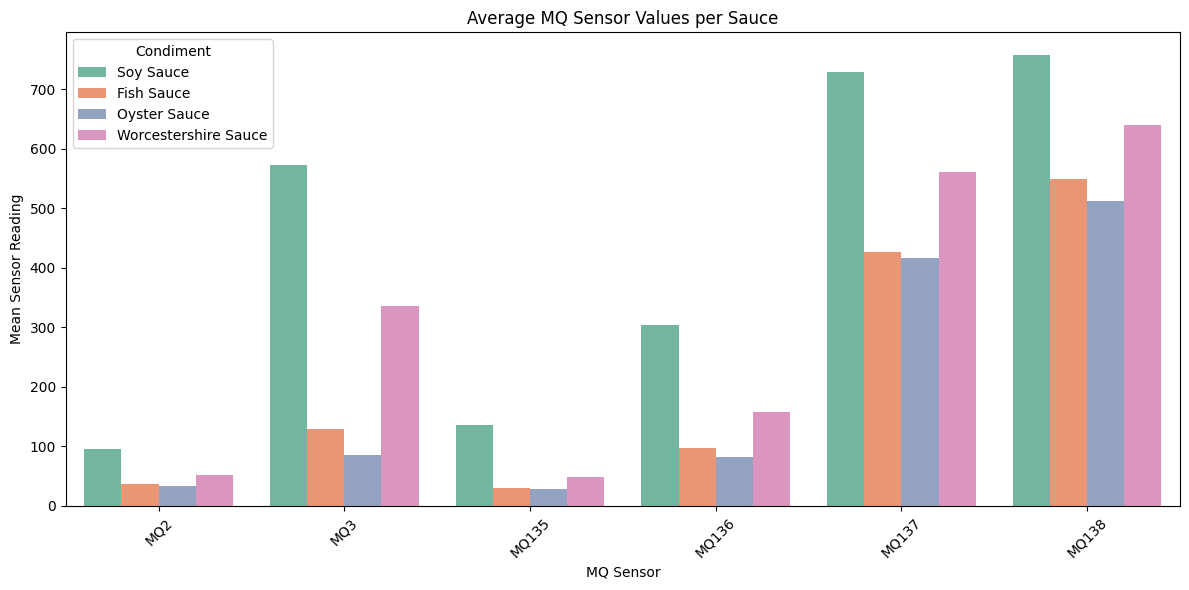

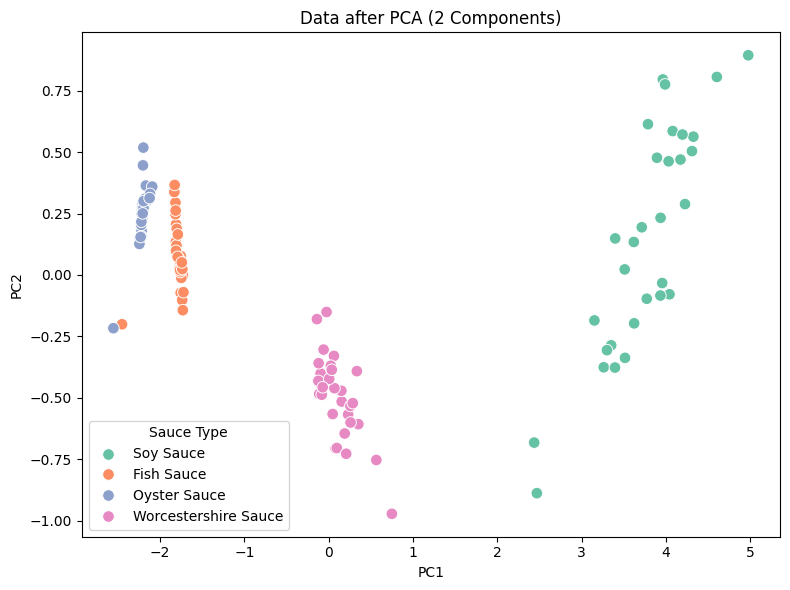

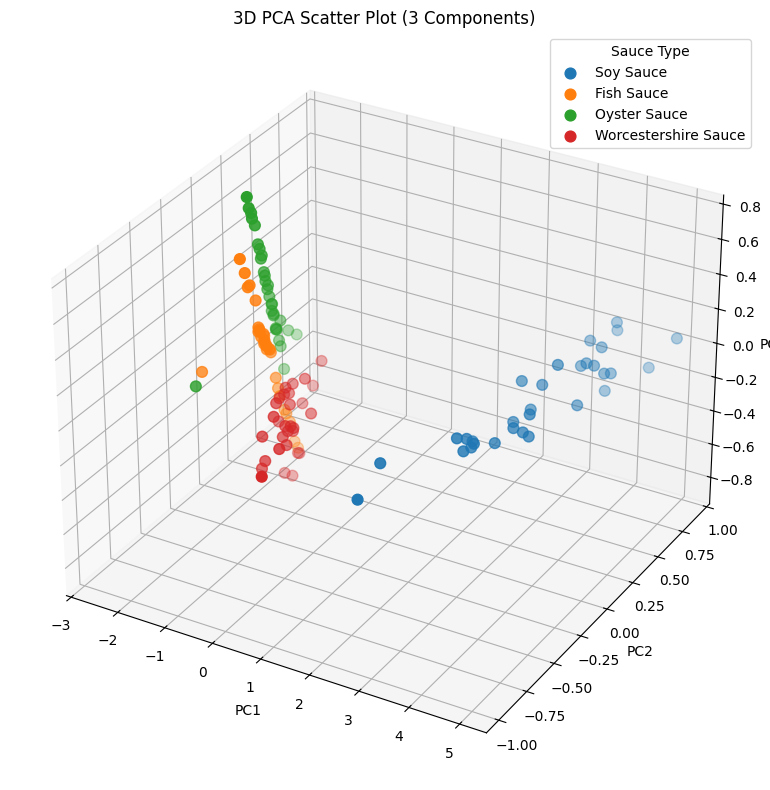

In [5]:
melted_df = main_voc_df.melt(
    id_vars="Label",
    value_vars=[col for col in main_voc_df.columns if "MQ" in col],
    var_name="Sensor",
    value_name="Value"
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted_df,
    x="Sensor",
    y="Value",
    hue="Label",
    ci=None,
    palette="Set2"
)

plt.title("Average MQ Sensor Values per Sauce")
plt.ylabel("Mean Sensor Reading")
plt.xlabel("MQ Sensor")
plt.xticks(rotation=45)
plt.legend(title="Condiment")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (n = 2) plot
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
pca_df_2d = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
pca_df_2d['Label'] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_2d, x="PC1", y="PC2", hue="Label", palette="Set2", s=70)
plt.title("Data after PCA (2 Components)")
plt.legend(title="Sauce Type")
plt.tight_layout()
plt.show()

# PCA ( = 3) plot
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
pca_df_3d = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
pca_df_3d['Label'] = y.values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for label in pca_df_3d['Label'].unique():
    subset = pca_df_3d[pca_df_3d['Label'] == label]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], label=label, s=60)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Scatter Plot (3 Components)')
ax.legend(title='Sauce Type')
plt.tight_layout()
plt.show()


Best Hyperparameters:


,Hyperparameter,Value
0,classifier__C,10.0
1,classifier__gamma,0.1
2,pca__n_components,2.0



Evaluation Metrics (Test Set):


,Metric,Value
0,Accuracy,1.0000
1,Macro F1 Score,1.0000



Classification Report:
                      precision    recall  f1-score   support

        Oyster Sauce       1.00      1.00      1.00         9
          Fish Sauce       1.00      1.00      1.00         9
           Soy Sauce       1.00      1.00      1.00        10
Worcestershire Sauce       1.00      1.00      1.00         9

            accuracy                           1.00        37
           macro avg       1.00      1.00      1.00        37
        weighted avg       1.00      1.00      1.00        37



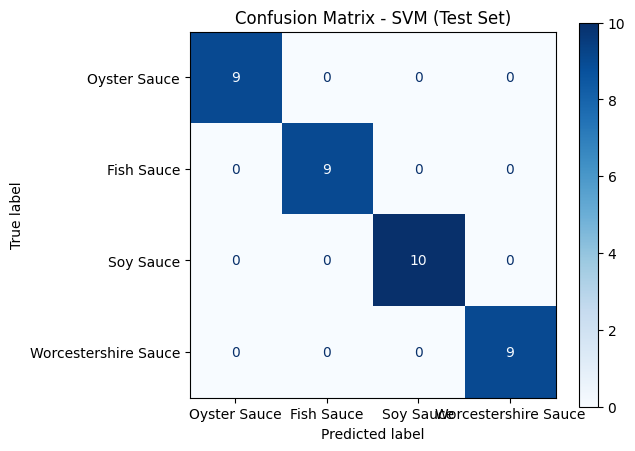


Misclassified Trials:


,True Label,Predicted Label,Correct



All Predictions:


,True Label,Predicted Label,Correct
80,Oyster Sauce,Oyster Sauce,True
86,Oyster Sauce,Oyster Sauce,True
89,Oyster Sauce,Oyster Sauce,True
41,Fish Sauce,Fish Sauce,True
76,Oyster Sauce,Oyster Sauce,True
7,Soy Sauce,Soy Sauce,True
103,Worcestershire Sauce,Worcestershire Sauce,True
75,Oyster Sauce,Oyster Sauce,True
59,Fish Sauce,Fish Sauce,True
28,Soy Sauce,Soy Sauce,True


In [ ]:
# Evaluate model on test set
predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
f1_macro = f1_score(y_test, predictions, average='macro')

best_params_df = pd.DataFrame(
    list(grid_search.best_params_.items()),
    columns=['Hyperparameter', 'Value']
 )
print("\nBest Hyperparameters:")
display(best_params_df)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1 Score'],
    'Value': [f"{accuracy:.4f}", f"{f1_macro:.4f}"]
})
print("\nEvaluation Metrics (Test Set):")
display(metrics_df)

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=y_test.unique()))

labels = y_test.unique()  # Preserves label order from test set
conf_matrix = confusion_matrix(y_test, predictions, labels=labels)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM (Test Set)")
plt.tight_layout()
plt.show()

results_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': predictions
})
results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

misclassified = results_df[~results_df['Correct']]

print("\nMisclassified Trials:")
display(misclassified)

print("\nAll Predictions:")
display(results_df)

In [8]:
# Predict labels for unseen data (features only, no metrics)
unseen_df = pd.read_csv('gathered_data_mean.csv')
if 'Label' in unseen_df.columns:
    X_unseen = unseen_df.drop(columns=['Label'])
else:
    X_unseen = unseen_df

predictions = best_model.predict(X_unseen)

predicted_df = pd.DataFrame({
    'Predicted Label': predictions
})
print("Predicted Labels for Unseen Data:")
display(predicted_df)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- MQ137
- MQ138


In [9]:
# Predict labels for unseen data (features only, no metrics)
unseen_df = pd.read_csv('fish_sauce_validation.csv')
if 'Label' in unseen_df.columns:
    X_unseen = unseen_df.drop(columns=['Label'])
else:
    X_unseen = unseen_df

predictions = best_model.predict(X_unseen)

predicted_df = pd.DataFrame({
    'Predicted Label': predictions
})
print("Predicted Labels for Unseen Data:")
pd.set_option('display.max_rows', None)
display(predicted_df)

FileNotFoundError: [Errno 2] No such file or directory: 'fish_sauce_validation.csv'